In [100]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))

# Verifique se os caminhos foram adicionados
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from pre_processing import create_domain, read_mesh
    from fem_processing import boundary_conditions, matrices_assembly, gaussian_quadrature
    from pos_processing import graph_results, fem_analysis
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects
Modules imports were successful!


# Project 2: Coaxial Cable with longitudinal symmetry

Considere a seção reta transversal de um cabo coaxial singelo apresentado na Figura $(1)$.

<figure>
    <img src="pre_processing/pictures/coaxial_longitudinal.png" alt="Fig.1" style="width:20%;" />
    <figcaption>Figure 1: Geometry of Coaxial Problem.</figcaption>
</figure>

# 3-noded Linear Triangular Elements, $P_1$
# Pre-processor module
## Geometry and mesh Domain

In [101]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0, 'name': 'outer_sheath'}]

MATERIAL = [{'tag': 201, 'name': 'core', 'relative_magnetic_permeability': 1},
            {'tag': 202, 'name': 'dielectric', 'relative_magnetic_permeability': 1},
            {'tag': 203, 'name': 'sheath', 'relative_magnetic_permeability': 1}]

# Criar geometria coaxial
create_domain.coaxial_longitudinal(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1E-3, view_mesh=False)

# Create mesh from file geometry
mesh_data = read_mesh.get_data(FINITE_ELEMENT, BOUNDARY, MATERIAL, model='coax_long')

Gerando malha com elementos triangulares de ordem P1 ...
Malha salva em pre_processing/mesh/coax_long_domain_Triangle1.msh
Model coax_long_domain_Triangle1 (2D)
Info     : 9 geometric entities
Info     : 4 Physical Groups
Info     : 1565 nodes in total
Info     : 3002 2-D elements in total


## Mesh Data Dictionaries

In [102]:
conn_data = mesh_data['conn_data']; conn_data[:1]

[{'TagID': 302,
  'conn_list': [585, 615, 526],
  'material': {'tag': 201,
   'name': 'core',
   'relative_magnetic_permeability': 1}}]

In [103]:
mesh_nodes = mesh_data['nodes_data']; mesh_nodes[:1]

[{'TagID': 1,
  'global_coord': (0.01, 0.0),
  'bc': {'type': 'Free', 'value': None}}]

## ``Nodes`` and ``conn`` list

In [104]:
nodes = [node['global_coord'] for node in mesh_data['nodes_data']]
conn = [element['conn_list'] for element in mesh_data['conn_data']]

## Figure 1: Coaxial meshed domain 

In [105]:
graph_results.plot_mesh(mesh_data, FINITE_ELEMENT, model='coax_long', Numbering=False)

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p21_coaxial_magnetostatics\pre_processing\pictures\coax_long_meshed_domain_Triangle1.svg


<figure>
    <img src="pre_processing/pictures/coax_long_meshed_domain_Triangle1.svg" alt="Fig.1" style="width:90%;" />
    <figcaption>Figure 1: Coaxial meshed domain.</figcaption>
</figure>

## ``global_nodes_coordinates()``

In [106]:
ai, xi, yi = matrices_assembly.global_nodes_coordinates(0, mesh_data)
print(f"'a_1' Global coordinates: {ai}")
print(f"'x_1' x-coordinates: {xi}")
print(f"'y_1' y-coordinates: {yi}")

'a_1' Global coordinates: [(-0.006838045274302086, 0.004491270025444997), (-0.007942853716170466, 0.00439813878217982), (-0.007329955473093625, 0.003660359087928205)]
'x_1' x-coordinates: [-0.006838045274302086, -0.007942853716170466, -0.007329955473093625]
'y_1' y-coordinates: [0.004491270025444997, 0.00439813878217982, 0.003660359087928205]


## `map_to_physical_coordinates()`

In [107]:
xi_master = (1, 0)
xg, yg = matrices_assembly.isomapping_to_global_coordinates(ai, xi_master, FINITE_ELEMENT)
print(f"'e_1' Master coordinates: {xi_master} --> Global coordinates: ({xg}, {yg})")

'e_1' Master coordinates: (1, 0) --> Global coordinates: (-0.007942853716170466, 0.00439813878217982)


## `apply_physics()`

In [108]:
mesh_data = ps.apply_physics(mesh_data, FINITE_ELEMENT)
mesh_data['conn_data'][:1]

[{'TagID': 302,
  'conn_list': [585, 615, 526],
  'material': {'tag': 201,
   'name': 'core',
   'relative_magnetic_permeability': 1},
  'source': {'type': 'uniform_current_density_Jz', 'value': 3183.098861837907},
  'stiffness_a_value': 795774.7150262763}]

## Material Proprieties, $k_a$

In [109]:
Ka = [cell['stiffness_a_value'] for cell in mesh_data['conn_data']]
Ma = [cell['mass_a_value'] for cell in mesh_data['conn_data'] if 'mass_a_value' in cell.keys()]
print("Stiffness Material values: ", Ka[:3])
print("Mass Material values: ", Ma[:3])

Stiffness Material values:  [795774.7150262763, 795774.7150262763, 795774.7150262763]
Mass Material values:  []


## Source: Current density, $J_z$

In [110]:
Jz = [element['source']['value'] for element in mesh_data['conn_data']]
print("Source current density vector Jz: \n", Jz[:1])

Source current density vector Jz: 
 [3183.098861837907]


## Jacobian Matrix Transform

In [111]:
Je = matrices_assembly.jacobian(e=0, mesh_data=mesh_data, element_type=FINITE_ELEMENT, xik=(0, 0)) 
Jdet, Jinv = np.linalg.det(Je), np.linalg.inv(Je)
print("Jacobian matrix for element e_0:\n", Je)
print("Determinant of the Jacobian matrix for element e_0:", Jdet)

Jacobian matrix for element e_0:
 [[-1.10480844e-03 -9.31312433e-05]
 [-4.91910199e-04 -8.30910938e-04]]
Determinant of the Jacobian matrix for element e_0: 8.721852098210453e-07


## Local Elements $e_1$

In [ ]:
Ae, fe, Me, area_e = matrices_assembly.higher_order_local_matrices(0, mesh_data, FINITE_ELEMENT)
print("Local stiffness matrix for element e_1:\n", Ae)
print("Local load vector for element e_1:\n", fe)
print("Area of element e_1: ", area_e)

Local stiffness matrix for element e_1:
 [[ 419683.44849477 -142122.51779549 -277560.93069928]
 [-142122.51779549  425351.90941478 -283229.39161929]
 [-277560.93069928 -283229.39161929  560790.32231857]]
Local load vector for element e_1:
 [[0.00046271]
 [0.00046271]
 [0.00046271]]
Area of element e_1:  4.360926005495966e-07


## Global “stiffness” matrix, $A_g$

In [113]:
Ag, fg, Mg = matrices_assembly.get_global_matrix(mesh_data, FINITE_ELEMENT)
print("Global matrix shape:", Ag.shape)

Global matrix shape: (1565, 1565)


## Imposition of Boundary Conditions

In [114]:
dirichlet_data = {node['TagID']: node['bc']['value'] for node in mesh_data['nodes_data'] if node['bc']['type'] == 'Dirichlet'}
Nu = len(mesh_data['nodes_data'])
Nd = len(dirichlet_data)
print(f"The entire domain has {Nu} nodes: {Nu - Nd} free nodes and {Nd} Dirichlet nodes.")

The entire domain has 1565 nodes: 1439 free nodes and 126 Dirichlet nodes.


## Mapping Global nodes to reduced system

This code creates a dictionary called ``global_to_reduced``, which maps the global indices of the mesh nodes to the reduced indices, i.e. the indices that correspond only to the nodes that are not in the _Dirichlet boundary conditions_.

In [115]:
global_to_reduced = {node: i for i, node in enumerate(
        idx_n for idx_n in range(1, len(nodes)+1) if idx_n not in dirichlet_data)}

# Processor Module
## Reduced Global matrix $A_{gr}$ with boundary conditions

In [116]:
Agr, fgr, Mgr = boundary_conditions.get_reduced_global_matrices(mesh_data, FINITE_ELEMENT)
print("Reduced global matrix shape:", Agr.shape)

Reduced global matrix shape: (1439, 1439)


## Global Potential Vector

In [117]:
ur = spsolve(Agr.tocsr(), fgr.toarray())
potential_u = boundary_conditions.get_global_potentials(mesh_data, ur)
print("Reduced solution vector ur shape: ", ur.shape)
print("Global potential vector V shape: ", potential_u.shape)

Reduced solution vector ur shape:  (1439,)
Global potential vector V shape:  (1565,)


## Solution at each element

In [118]:
u_list = []
for e in range(len(conn)):
    uh_values = [potential_u[id - 1] for id in conn[e]]
    u_list.append(uh_values)
print("The solution u for Node Element is: \n", np.array(u_list[:3]))

The solution u for Node Element is: 
 [[1.57724758e-07 1.42231856e-07 1.57518825e-07]
 [1.55757395e-07 1.59264263e-07 1.42052741e-07]
 [1.42052741e-07 1.38423459e-07 1.55757395e-07]]


# Post-Processor

In [119]:
graph_results.approximate_fem_solution(FINITE_ELEMENT, mesh_data, potential_u, model='coax_long')

Arquivo salvo em: c:\Users\adilt\OneDrive\01 ACADEMIA\06 MODELOS\8.FEM\ppgee\projects\p21_coaxial_magnetostatics\pos_processing\pictures\coax_long_domain_solution_Triangle1.svg


### Figure 2: Scalar Field Distribution on a Triangular Mesh

<figure>
    <img src="pos_processing/pictures/coax_long_domain_solution_Triangle1.svg" alt="Fig.2" style="width:90%;" />
    <figcaption>Figure 2: Scalar Field Distribution on a Triangular Mesh.</figcaption>
</figure>

### Magnetic Energy Stored

In [120]:
analytical_solution = lambda x, y: ps.potential_and_gradient(x, y)
norm_l2, norm_energy, total_energy = fem_analysis.errors_and_energy(
            mesh_data, FINITE_ELEMENT, potential_u, analytical_solution)
print(f"Total magnetic energy stored: {total_energy:.5} J.")

Total magnetic energy stored: 8.4586e-08 J.


### `magnetic_field()`

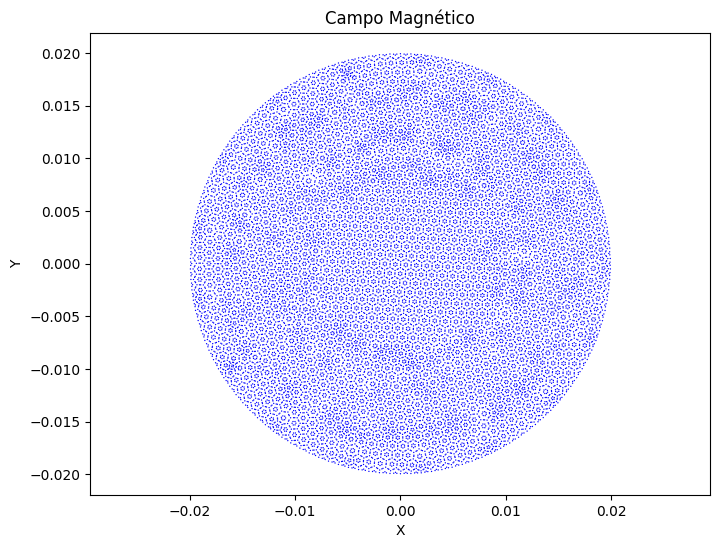

In [ ]:
conn = [element['conn_list'] for element in mesh_data['conn_data']]
B_global = np.zeros((len(conn), 2))  # Campo magnético nos nós
contagem = np.zeros(len(conn))  # Contagem de contribuições nos nós
x_coords, y_coords, Bx, By = [], [], [], []  # Para visualização

type, order = FINITE_ELEMENT
try:
    if type == 'Triangle' and order in [1, 2, 3]:
        gauss_points, _ = gaussian_quadrature.general_triangle_rule(m=7, p=5)
    elif type == 'Quadrangle':
        gauss_points, _ = gaussian_quadrature.square_rule(ng=9)
    else:
        raise ValueError("Tipo de elemento ou ordem não suportados.")
except Exception as e:
    raise RuntimeError(f"Erro na seleção de quadratura: {e}")

for e in range(len(conn)):
    # Potencial em cada nó do elemento
    uh_e = [potential_u[node - 1] for node in conn[e]]

    # Coordenadas globais dos nós do elemento
    ai, xi, yi = matrices_assembly.global_nodes_coordinates(e, mesh_data)
    
    for xik in gauss_points:
        # Coordenadas globais no ponto de Gauss
        xg, yg = matrices_assembly.isomapping_to_global_coordinates(ai, xik, FINITE_ELEMENT)

        # Jacobiano e suas propriedades
        Je = matrices_assembly.jacobian(e, mesh_data, FINITE_ELEMENT, xik)
        Jdet, Je_inv = np.linalg.det(Je), np.linalg.inv(Je)
        if np.abs(Jdet) < 1e-12:
            raise ValueError(f"Jacobiano com determinante próximo de zero no elemento {e}.")
        
        # Gradientes das funções de forma no domínio mestre
        _, _, _, gradN = matrices_assembly.derivatives_at_master_domain(xik, FINITE_ELEMENT)
        grad_phi = Je_inv @ gradN

        # Rotação para calcular o campo magnético
        rotate = np.array([[0, -1], [1, 0]])
        b_field = rotate @ grad_phi

        # Campo magnético interpolado usando o potencial do elemento
        b_field_uh = np.dot(b_field, uh_e)
        B_x, B_y = b_field_uh[0], b_field_uh[1]
        
        # Acumular valores nos nós do elemento
        for i, no in enumerate(conn[e]):
            B_global[no, 0] += B_x  # Acumula Bx
            B_global[no, 1] += B_y  # Acumula By
            contagem[no] += 1  # Conta as contribuições

        # Acumular para visualização
        x_coords.append(xg)
        y_coords.append(yg)
        Bx.append(B_x)
        By.append(B_y)

# Normalizar o campo magnético nos nós globais
contagem[contagem == 0] = 1e-12  # Evitar divisão por zero
B_global[:, 0] /= contagem
B_global[:, 1] /= contagem

# Converter dados para visualização
x_coords, y_coords = np.array(x_coords), np.array(y_coords)
Bx, By = np.array(Bx), np.array(By)

# Visualização do campo magnético
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.quiver(x_coords, y_coords, Bx, By, angles='xy', scale_units='xy', scale=1, color='blue')
plt.title("Campo Magnético")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.